In [69]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import astropy.io.ascii as aa
import gzip
from matplotlib.colors import LogNorm
import os.path as op
import pickle
import plotutils.plotutils as pu
import pystan
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [56]:
seaborn.set_style('ticks')

In [2]:
data_dir = '/Users/farr/Documents/Research/KepHackWeek/data'

In [3]:
candidates = aa.read(op.join(data_dir, 'dr24_koi.csv'))
candidates = candidates[(candidates['koi_pdisposition']=='CANDIDATE') & (candidates['koi_max_mult_ev'] >= 15.0)]
candidates

kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,koi_gmag_err,koi_rmag,koi_rmag_err,koi_imag,koi_imag_err,koi_zmag,koi_zmag_err,koi_jmag,koi_jmag_err,koi_hmag,koi_hmag_err,koi_kmag,koi_kmag_err,koi_kepmag,koi_kepmag_err,koi_delivname,koi_vet_stat,koi_quarters,koi_disposition,koi_pdisposition,koi_count,koi_num_transits,koi_max_sngle_ev,koi_max_mult_ev,koi_bin_oedp_sig,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_trans_mod,koi_model_snr,koi_model_dof,koi_model_chisq,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_period,koi_period_err1,koi_period_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dicco_fra,koi_dicco_fra_err,koi_dicco_fdec,koi_dicco_fdec_err,koi_dicco_fsky,koi_dicco_fsky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,koi_dikco_fra,koi_dikco_fra_err,koi_dikco_fdec,koi_dikco_fdec_err,koi_dikco_fsky,koi_dikco_fsky_err,koi_comment,koi_vet_date,koi_tce_plnt_num,koi_tce_delivname,koi_datalink_dvs,koi_disp_prov,koi_parm_prov,koi_time0,koi_time0_err1,koi_time0_err2,koi_datalink_dvr,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype
int64,str9,str14,float64,float64,str12,float64,float64,str12,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,str15,str4,float64,str14,str14,int64,int64,float64,float64,int64,str33,float64,float64,float64,float64,str34,float64,int64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,str225,str10,int64,str15,str64,str15,str15,float64,float64,float64,str60,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,str4
7697568,K01829.01,--,296.52243,0.0,19h46m05.38s,43.363369,0.0,+43d21m48.1s,16.591,--,15.841,--,15.62,--,15.448,--,14.437,0.029,14.033,0.031,13.865,0.049,15.911,--,q1_q17_dr24_koi,Done,1.11111111111e+30,CANDIDATE,CANDIDATE,2,57,12.036085,50.30746,--,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2223,0.4689,Mandel and Agol (2002 ApJ 580 171),60.5,--,--,138.63416,0.00119,-0.00119,0,--,--,--,--,--,23.37,8.48,-1.93,0.1499,--,--,1.1845,0.5157,-0.1152,2.6837,0.0633,-0.0633,--,--,--,3390.3,71.2,-71.2,22.84151055,3.352e-05,-3.352e-05,0.260388,0.504439,-0.100065,28.03,6.5,-6.5,87.66,--,--,556.

In [4]:
pbins = loadtxt('pbins.dat.gz')
rbins = loadtxt('rbins.dat.gz')

In [5]:
geffs = loadtxt('g-integrated-eff.dat.gz')
gids = geffs[:,0].astype(np.int)
geffs = geffs[:,1:].reshape((-1, pbins.shape[0]-1, rbins.shape[0]-1))

In [6]:
pobs = []
robs = []
drobs = []
gidset = set(gids)
for c in candidates:
    if c['kepid'] in gidset:
        pobs.append(c['koi_period'])
        robs.append(c['koi_prad'])
        drobs.append(0.5*(c['koi_prad_err1'] - c['koi_prad_err2']))
pobs = array(pobs)
robs = array(robs)
drobs = array(drobs)
nansel = (np.isnan(pobs) | np.isnan(robs) | np.isnan(drobs))
pobs = pobs[~nansel]
robs = robs[~nansel]
drobs = drobs[~nansel]
zerosel = ((pobs == 0) | (robs == 0) | (drobs == 0))
pobs = pobs[~zerosel]
robs = robs[~zerosel]
drobs = drobs[~zerosel]
outsel = (pobs < pbins[0]) | (pobs > pbins[-1])
pobs = pobs[~outsel]
robs = robs[~outsel]
drobs = drobs[~outsel]

/Users/farr/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [7]:
alphas = sum(geffs, axis=0)

In [8]:
data = {'Ncand': len(pobs),
        'Npbins' : len(pbins)-1,
        'Nrbins' : len(rbins)-1,
        'pbins': pbins,
        'rbins': rbins,
        'pobs': pobs,
        'robs': robs,
        'drobs': drobs,
        'alphas': alphas}

In [62]:
fit = pystan.stan(file='binned_model.stan', data=data)

/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Applications/Canopy.app/appdata/canopy-1.5.5.3123.macosx-x86_64/Canopy.app/Contents/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled 

In [63]:
fit

Inference for Stan model: anon_model_a50c4a2b034b45009632670e9f8bbfc5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logrs_raw[0]               0.33    0.71   1.01  -0.67  -0.46  -0.05   1.23    2.0    2.0  79.19
logrs_raw[1]               0.07    0.26   0.37  -0.24   -0.2   -0.1   0.37   0.73    2.0  15.85
logrs_raw[2]               0.41    0.28   0.39  -0.07   0.13   0.29   0.64   1.11    2.0  13.14
logrs_raw[3]              -0.04    0.37   0.53  -0.64  -0.47  -0.18   0.41   0.81    2.0  77.47
logrs_raw[4]              -0.28    0.66   0.94  -1.72  -1.14  -0.12   0.51   0.83    2.0  55.98
logrs_raw[5]               0.36    0.14    0.2   0.16   0.19   0.24   0.55    0.7    2.0   5.94
logrs_raw[6]              -0.19    0.39   0.56  -1.09  -0.59  -0.08   0.32   0.44    2.0  14.04
logrs_raw[7]               0.38    0.57   0

In [64]:
chains = fit.extract(permuted=True)

In [70]:
with gzip.open('bu-chains.pkl.gz', 'w') as out:
    pickle.dump(chains, out)

<matplotlib.colorbar.Colorbar instance at 0x12598b758>

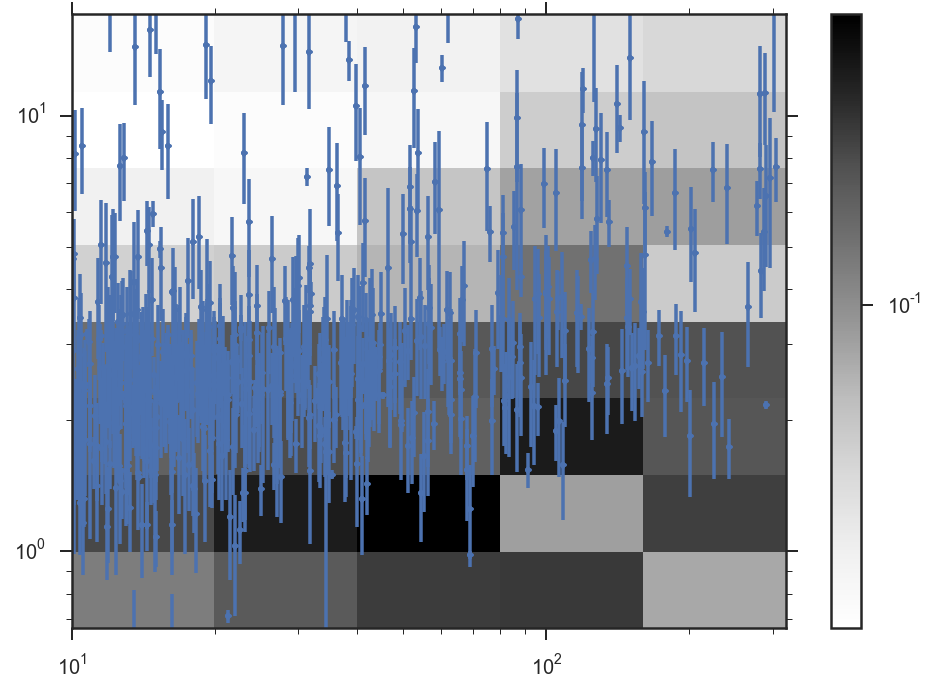

In [66]:
errorbar(pobs, robs, yerr=drobs, xerr=0, fmt='.')
xscale('log')
yscale('log')
PS, RS = meshgrid(pbins, rbins, indexing='ij')
pcolormesh(PS, RS, mean(chains['dndlogpdlogr'], axis=0), norm=LogNorm())
axis(xmin=pbins[0], xmax=pbins[-1], ymin=rbins[0], ymax=rbins[-1])
colorbar()

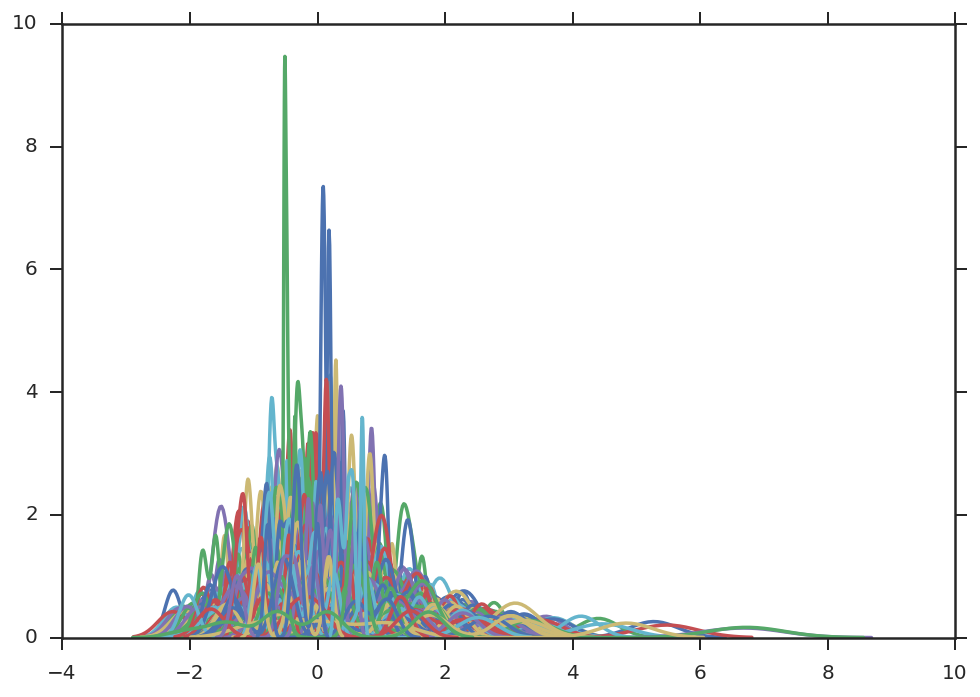

In [67]:
for i in range(pobs.shape[0]):
    pu.plot_kde_posterior((chains['rs'][:,i]-robs[i])/drobs[i])

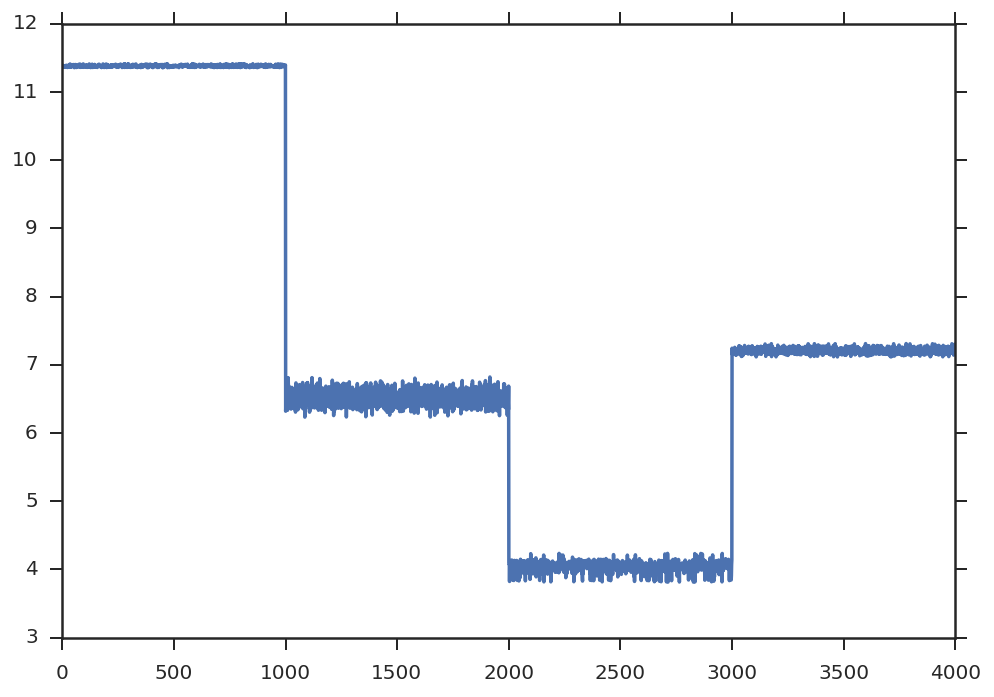

In [68]:
plot(chains['rs'][:,15])